In [21]:
from mario_scenes.load_data import load_clips_sidecars

In [22]:
sidecars_df = load_clips_sidecars('../../mario.scenes/data/mario/derivatives/scene_clips')
sidecars_df

,Subject,Session,Run,Level,Scene,ClipCode,StartFrame,EndFrame,TotalFrames,bk2_filepath,...,Duration,Cleared,Final_score,Final_position,Lives_lost,Hits_taken,Enemies_killed,Powerups_collected,Bricks_destroyed,Coins
0,01,001,04,1,5,00104040000645,645,882,2845,sub-01/ses-001/gamelogs/sub-01_ses-001_task-ma...,...,3.950000,True,0,1088,0,0,0,0,0,0
1,01,001,03,3,4,00103070001190,1190,1396,2690,sub-01/ses-001/gamelogs/sub-01_ses-001_task-ma...,...,3.433333,True,20,950,1,0,0,0,0,1
2,01,001,01,1,10,00101050001524,1524,1712,2626,sub-01/ses-001/gamelogs/sub-01_ses-001_task-ma...,...,3.133333,True,60,2292,0,0,0,0,0,2
3,01,001,01,1,14,00101030001518,1518,1726,2437,sub-01/ses-001/gamelogs/sub-01_ses-001_task-ma...,...,3.466667,True,90,3031,0,0,0,0,0,2
4,01,001,03,3,5,00103080000691,691,997,2597,sub-01/ses-001/gamelogs/sub-01_ses-001_task-ma...,...,5.100000,True,20,1122,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56019,06,025,05,1,3,02505050000360,360,596,3495,sub-06/ses-025/gamelogs/sub-06_ses-025_task-ma...,...,3.933333,True,0,705,0,0,0,0,0,0
56020,06,025,04,2,13,02504030006825,6825,7320,12456,sub-06/ses-025/gamelogs/sub-06_ses-025_task-ma...,...,8.250000,True,660,2339,1,0,0,0,0,23
56021,06,025,05,3,10,02505060003079,3079,3228,3686,sub-06/ses-025/gamelogs/sub-06_ses-025_task-ma...,...,2.483333,True,310,2299,0,0,0,0,0,12
56022,06,025,02,2,0,02502000000126,126,538,6297,sub-06/ses-025/gamelogs/sub-06_ses-025_task-ma...,...,6.866667,True,0,223,0,0,0,0,0,0


In [23]:
# Add some replay-level info to clips sidecars

replays_dir = '../../mario.replays/data/mario/derivatives/replays'

import os.path as op
import json

for i, row in sidecars_df.iterrows():
    json_path = row['bk2_filepath'].replace('bk2', 'json')
    with open(op.join(replays_dir, json_path)) as f:
        replay_sidecar = json.load(f)
    sidecars_df.loc[i, 'replay_global_idx'] = replay_sidecar['global_idx']
    sidecars_df.loc[i, 'phase'] = replay_sidecar['phase']
    sidecars_df.loc[i, 'replay_level_idx'] = replay_sidecar['level_idx']
    sidecars_df.loc[i, 'replay_idx_in_run'] = replay_sidecar['idx_in_run']

In [24]:
sidecars_df.to_csv('clips_sidecars.csv', index=False)

In [25]:
sidecars_df.keys()

Index(['Subject', 'Session', 'Run', 'Level', 'Scene', 'ClipCode', 'StartFrame',
       'EndFrame', 'TotalFrames', 'bk2_filepath', 'GameName', 'World',
       'Duration', 'Cleared', 'Final_score', 'Final_position', 'Lives_lost',
       'Hits_taken', 'Enemies_killed', 'Powerups_collected',
       'Bricks_destroyed', 'Coins', 'replay_global_idx', 'phase',
       'replay_level_idx', 'replay_idx_in_run'],
      dtype='object')

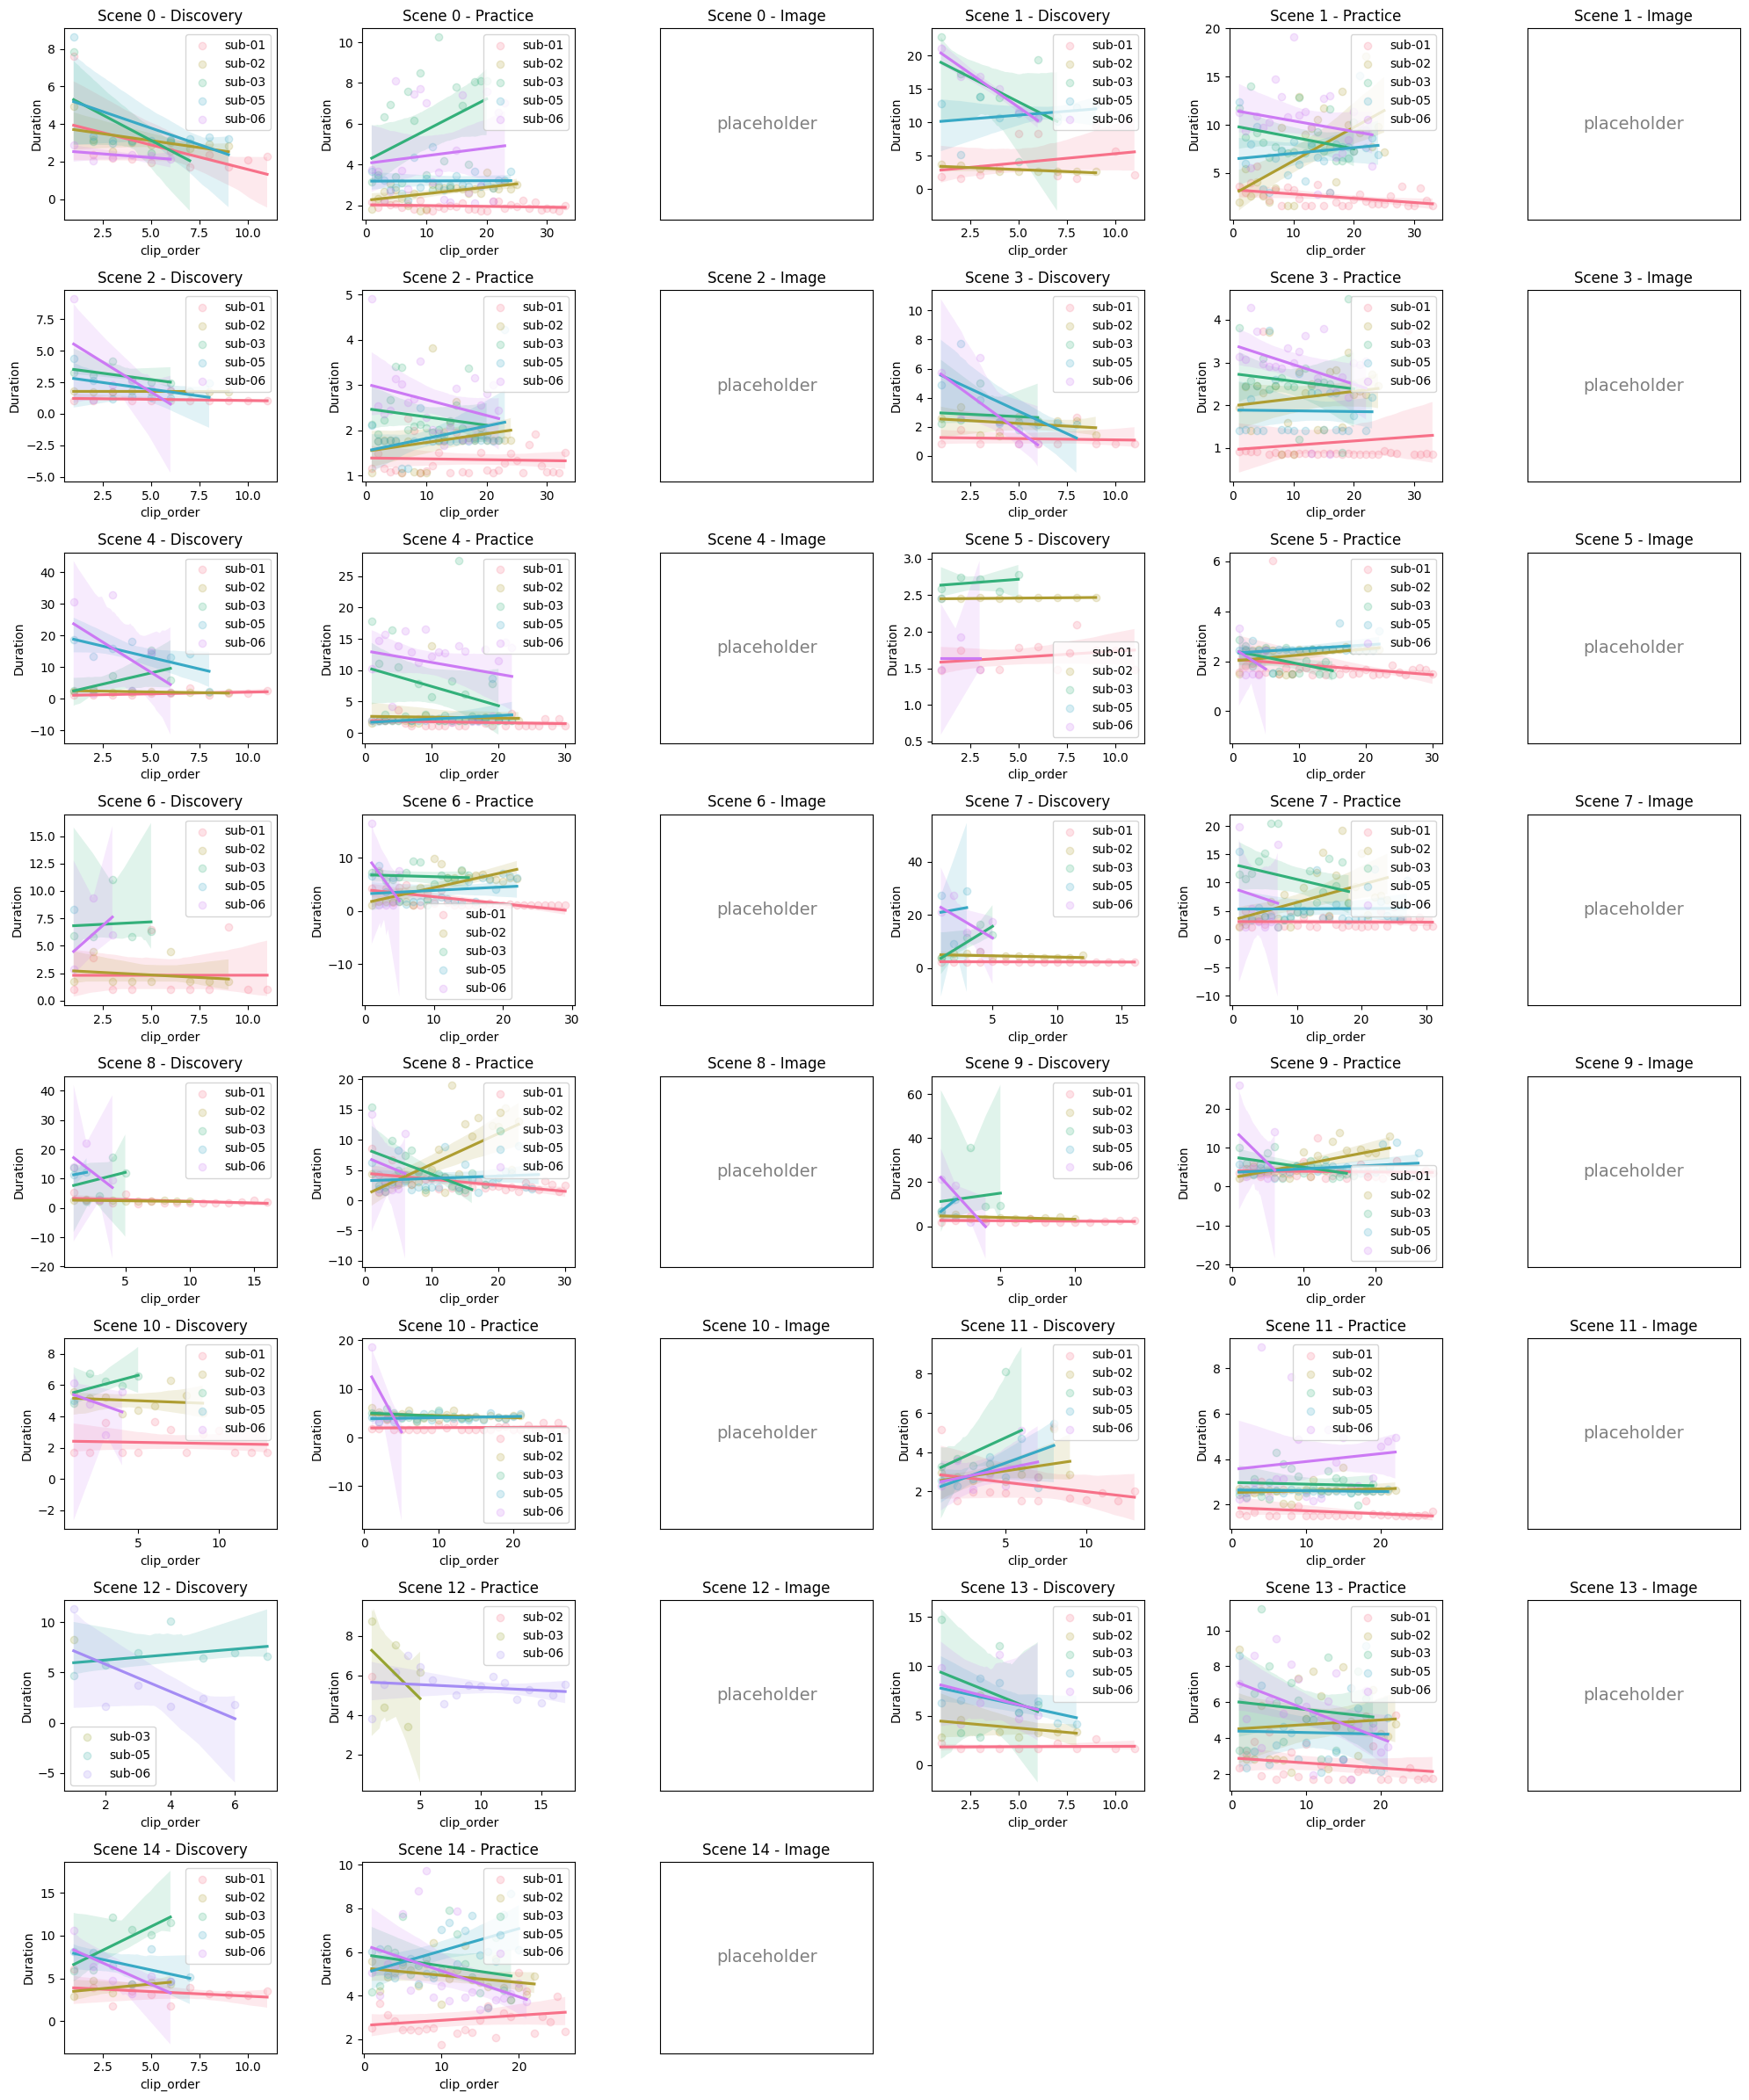

In [49]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpecFromSubplotSpec

def create_panel_of_graphs(clips_sidecars, world, level, y_col):
    """
    Creates a panel of graphs for each unique scene in a given world and level.
    
    Parameters:
    - clips_sidecars: pandas DataFrame containing at least the columns:
        'World', 'Level', 'Scene', 'phase', 'Subject', 'ClipCode', and a y-axis column.
    - world: The world identifier to filter the dataframe.
    - level: The level identifier to filter the dataframe.
    - y_col: The name of the column to use for the y-axis in the regplots.
    
    For each scene (a unique combination of World, Level, Scene), the function creates
    a composite figure with three subplots:
        1. A regplot for the 'discovery' phase.
        2. A regplot for the 'practice' phase.
        3. A placeholder subplot displaying "placeholder".
        
    The x-axis is computed as the absolute order of the clips based on the 'ClipCode'
    value. This ordering is calculated for each subject and each phase separately.
    
    Scenes are plotted in numerical order (e.g., 0 to 12) from left to right and top to bottom.
    The regplots display 95% confidence intervals and the legend labels use the "sub-XX" format.
    """
    
    # Filter dataframe by world and level
    df_filtered = clips_sidecars[(clips_sidecars['World'] == str(world)) & 
                                 (clips_sidecars['Level'] == str(level))]
    
    # Ensure scenes are ordered numerically (assuming they are convertible to int)
    scenes = sorted(df_filtered['Scene'].unique(), key=lambda x: int(x))
    n_scenes = len(scenes)
    
    # Determine grid dimensions: 2 columns, enough rows to cover all scenes
    n_cols = 2
    n_rows = math.ceil(n_scenes / n_cols)
    
    # Create a figure with the overall grid of axes
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))
    axs = axs.flatten() if n_scenes > 1 else [axs]
    
    # Loop through each scene and create the composite plots
    for idx, scene in enumerate(scenes):
        ax_parent = axs[idx]
        # Hide the parent axis (we'll embed our own subplots into it)
        ax_parent.set_visible(False)
        
        # Filter dataframe for the current scene and make a copy
        df_scene = df_filtered[df_filtered['Scene'] == scene].copy()
        
        # For each subject and phase in this scene, compute the clip order based on 'ClipCode'
        df_scene = df_scene.sort_values(['Subject', 'phase', 'ClipCode'])
        df_scene['clip_order'] = df_scene.groupby(['Subject', 'phase']).cumcount() + 1
        
        # Create a sub-grid for the three subplots in this scene panel
        gs = GridSpecFromSubplotSpec(1, 3, subplot_spec=ax_parent.get_subplotspec(), wspace=0.4)
        ax_discovery = fig.add_subplot(gs[0])
        ax_practice = fig.add_subplot(gs[1])
        ax_placeholder = fig.add_subplot(gs[2])
        
        # Get unique subjects in this scene and assign colors
        subjects = df_scene['Subject'].unique()
        palette = sns.color_palette("husl", len(subjects))
        
        # Plot for discovery phase with confidence intervals
        for i, subject in enumerate(subjects):
            df_sub = df_scene[(df_scene['Subject'] == subject) & (df_scene['phase'] == 'discovery')]
            if not df_sub.empty:
                sns.regplot(x='clip_order', y=y_col, data=df_sub, ax=ax_discovery,
                            scatter=True, color=palette[i],
                            marker='o', label=f"sub-{subject}", ci=95, scatter_kws={'alpha':0.2})
        ax_discovery.set_title(f"Scene {scene} - Discovery")
        if len(subjects) > 1:
            ax_discovery.legend()
        
        # Plot for practice phase with confidence intervals
        for i, subject in enumerate(subjects):
            df_sub = df_scene[(df_scene['Subject'] == subject) & (df_scene['phase'] == 'practice')]
            if not df_sub.empty:
                sns.regplot(x='clip_order', y=y_col, data=df_sub, ax=ax_practice,
                            scatter=True, color=palette[i],
                            marker='o', label=f"sub-{subject}", ci=95, scatter_kws={'alpha':0.2})
        ax_practice.set_title(f"Scene {scene} - Practice")
        if len(subjects) > 1:
            ax_practice.legend()
        
        # Placeholder subplot for future image
        ax_placeholder.text(0.5, 0.5, "placeholder", 
                            horizontalalignment='center', verticalalignment='center',
                            fontsize=14, color='gray')
        ax_placeholder.set_xticks([])
        ax_placeholder.set_yticks([])
        ax_placeholder.set_title(f"Scene {scene} - Image")
    
    # Hide any unused axes if the grid is larger than needed
    for j in range(n_scenes, len(axs)):
        axs[j].set_visible(False)
    
    plt.tight_layout()
    return fig

fig = create_panel_of_graphs(sidecars_df, 1, 1, 'Duration')


In [ ]:
# Filter dataframe by world and level
df_filtered = sidecars_df[(sidecars_df['World'] == 1) & 
                          (sidecars_df['Level'] == 1)]

In [37]:
df_filtered.keys()

Index(['Subject', 'Session', 'Run', 'Level', 'Scene', 'ClipCode', 'StartFrame',
       'EndFrame', 'TotalFrames', 'bk2_filepath', 'GameName', 'World',
       'Duration', 'Cleared', 'Final_score', 'Final_position', 'Lives_lost',
       'Hits_taken', 'Enemies_killed', 'Powerups_collected',
       'Bricks_destroyed', 'Coins', 'replay_global_idx', 'phase',
       'replay_level_idx', 'replay_idx_in_run'],
      dtype='object')

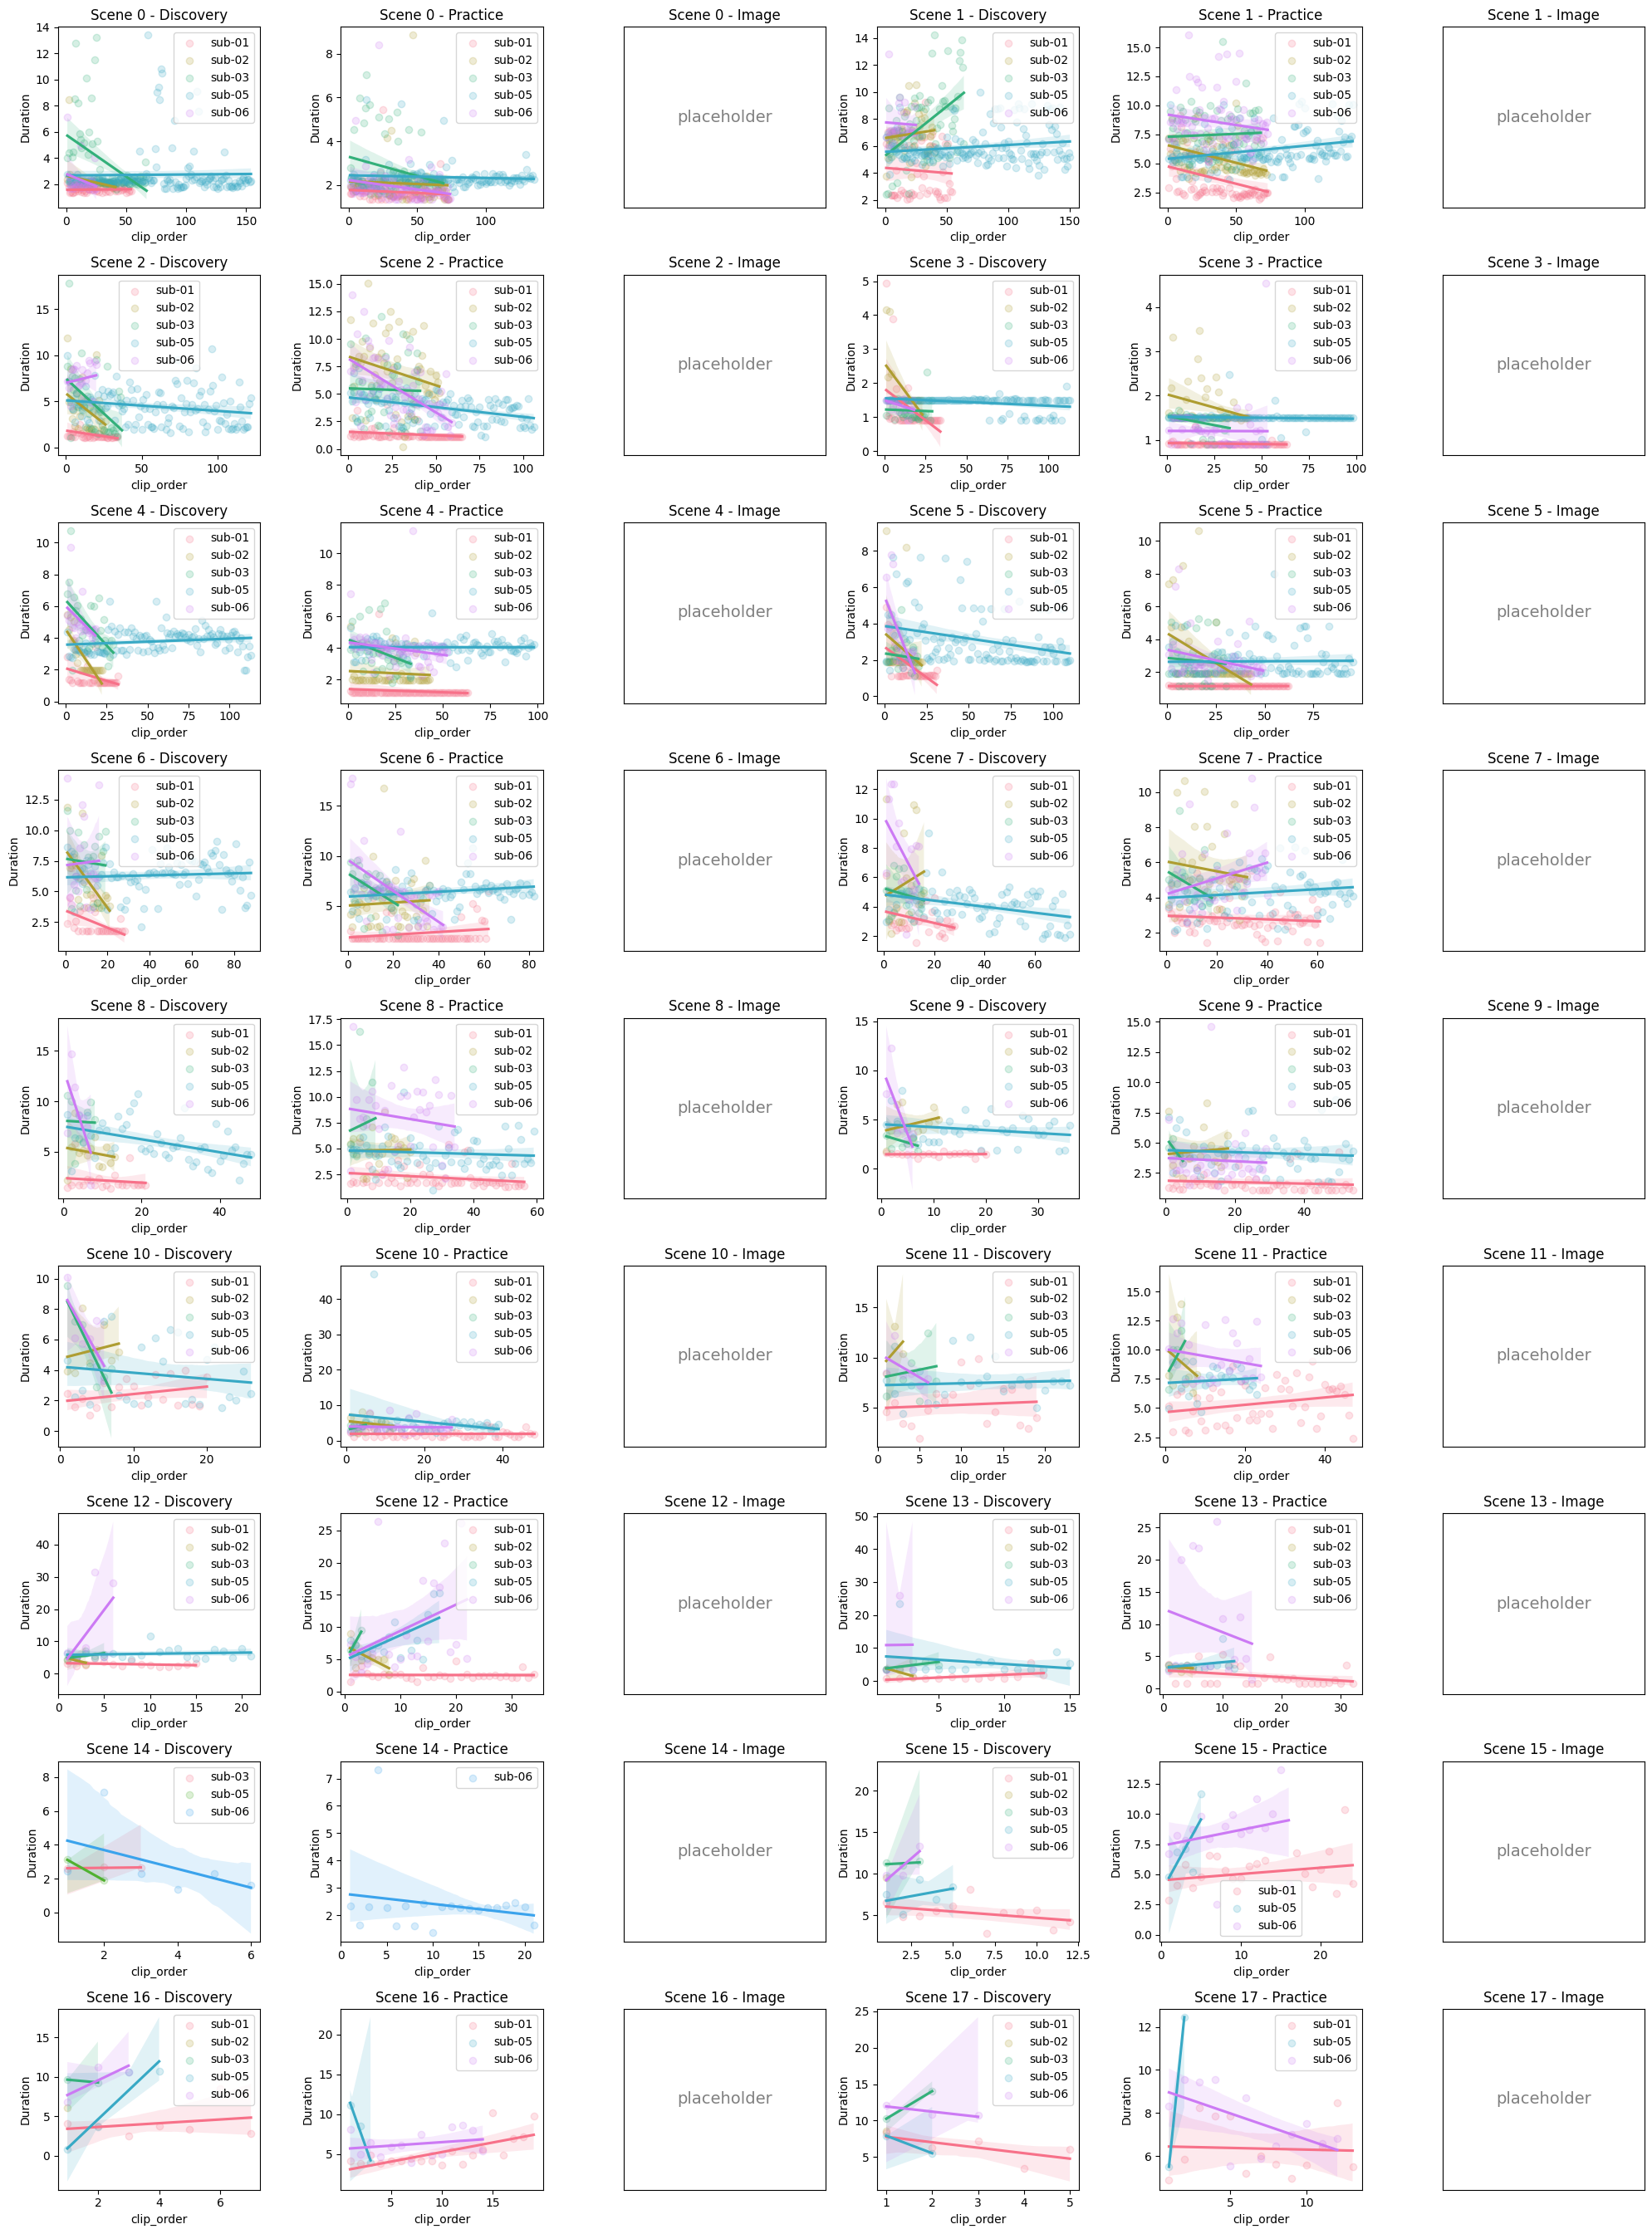

In [50]:
fig = create_panel_of_graphs(sidecars_df, 8, 2, 'Duration')

In [43]:
sidecars_df['Final_score']

0          0
1         20
2         60
3         90
4         20
        ... 
56019      0
56020    660
56021    310
56022      0
56023    210
Name: Final_score, Length: 56024, dtype: int64